There have been some issues regarding the correlation between CV and leaderboard scores in this competition. Every top-scoring public kernel has a much lower CV score than leaderboard score. It has also been very frustrating to tune a model to optimal CV score only to discover that the score on the Leaderboard is abysmal.

In this kernel I am going to address this issue and propose a framework for robust local validation. The preprocessing and model architecture have stayed mostly the same as in [my previous kernel](https://www.kaggle.com/bminixhofer/deterministic-neural-networks-using-pytorch).

I'll also write about the impact of seeds on the score.

Again, we'll start with standard imports.

# Imports

In [1]:
# standard imports
import time
import random
import os
from IPython.display import display
import numpy as np
import pandas as pd
from scipy import stats
import warnings

# pytorch imports
import torch
import torch.nn as nn
import torch.utils.data

# imports for preprocessing the questions
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# progress bars
from tqdm import tqdm
tqdm.pandas()

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", message="F-score is ill-defined and being set to 0.0 due to no predicted samples.")
%matplotlib inline

Using TensorFlow backend.


# Loading the data

In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print('Train data dimension: ', train_df.shape)
display(train_df.head())
print('Test data dimension: ', test_df.shape)
display(test_df.head())

Train data dimension:  (1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Test data dimension:  (375806, 2)


,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [3]:
enable_local_test = True
if enable_local_test:
    n_test = len(test_df)
    train_df, local_test_df = (train_df.iloc[:-n_test].reset_index(drop=True), 
                               train_df.iloc[-n_test:].reset_index(drop=True))
else:
    local_test_df = pd.DataFrame([[None, None, 0], [None, None, 0]], columns=['qid', 'question_text', 'target'])
    n_test = 2

Here, we create a dataframe I call `local_test_df`. We will pretend that this dataframe is the actual test dataframe. The only difference: We know the labels for this one! So we do not have to blindly submit our model and pray for a good score, but can instead tune the score we achieve on this test dataframe. I have set the size of the local test dataframe to 4 times the size of the public test dataframe. That is a reasonable size (~200k rows) but more or less arbitrary.

So we are going to test our model on two sets now: First, the regular test set, and second, a local test set which we know the labels for. Overall, the procedure is:

- split the data in a train and local test set
- perform CV on the train set
- when tuning the model:
    - evaluate the predictions on the local test set
- when submitting:
    - predict the samples in the true test set
    - make the size of the local test set 0 for best performance (set `enable_local_test` to False)
    
    
We actually perform CV on the train side of a regular train / test split. It would be ideal to wrap the whole thing in another K-Fold cross validation procedure. That is, however, not feasible regarding computing power on my local machine and in the kaggle kernels.

# Utility functions

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)], disable=True):
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Processing input

In [7]:
embed_size = 300
max_features = 95000
maxlen = 70

In [8]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

In [9]:
for df in [train_df, test_df, local_test_df]:
    df["question_text"] = df["question_text"].str.lower()
    df["question_text"] = df["question_text"].apply(lambda x: clean_text(x))
    df["question_text"].fillna("_##_", inplace=True)
    
x_train = train_df["question_text"].values
x_test = test_df["question_text"].values
x_test_local = local_test_df["question_text"].values

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train) + list(x_test_local))
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_test_local = tokenizer.texts_to_sequences(x_test_local)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
x_test_local = pad_sequences(x_test_local, maxlen=maxlen)

y_train = train_df['target'].values
y_test = local_test_df['target'].values

# Creating the embeddings matrix

In [10]:
def load_glove(word_index, max_features):
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    
    embeddings_index = []
    for o in tqdm(open(EMBEDDING_FILE)):
        try:
            embeddings_index.append(get_coefs(*o.split(" ")))
        except Exception as e:
            print(e)
    
    embeddings_index = dict(embeddings_index)
            
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index) + 1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_fasttext(word_index, max_features):    
    EMBEDDING_FILE = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    
    embeddings_index = []
    for o in tqdm(open(EMBEDDING_FILE)):
        if len(o) <= 100:
            continue
        
        try:
            coefs = get_coefs(*o.split(" "))
            assert len(coefs[1]) == 300
            embeddings_index.append(coefs)
        except Exception as e:
            print(e)

    embeddings_index = dict(embeddings_index)
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    nb_words = min(max_features, len(word_index) + 1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

def load_para(word_index, max_features):
    EMBEDDING_FILE = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = []
    for o in tqdm(open(EMBEDDING_FILE, encoding="utf8", errors='ignore')):
        if len(o) <= 100:
            continue
        try:
            coefs = get_coefs(*o.split(" "))
            assert len(coefs[1]) == 300
            embeddings_index.append(coefs)
        except Exception as e:
            print(e)
    
    embeddings_index = dict(embeddings_index)
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index) + 1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [11]:
seed_everything()

glove_embeddings = load_glove(tokenizer.word_index, max_features)
paragram_embeddings = load_para(tokenizer.word_index, max_features)

embedding_matrix = np.mean([glove_embeddings, paragram_embeddings], axis=0)
np.shape(embedding_matrix)

2196017it [02:36, 14044.91it/s]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
1703756it [02:03, 13756.51it/s]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(95000, 300)

# Defining the model

The only thing I changed about the model is the size of the LSTM and GRU. They had 40 hidden units previously and 60 now. I also changed the number of K-Fold splits to 4.

In [12]:
splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=10).split(x_train, y_train))

In [13]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 1, keepdim=True) + 1e-10

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)
    
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

In [14]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        hidden_size = 60
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        self.embedding_dropout = SpatialDropout(0.1)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)
        
        self.lstm_attention = Attention(hidden_size * 2, maxlen)
        self.gru_attention = Attention(hidden_size * 2, maxlen)
        
        self.linear = nn.Linear(480, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(16, 1)
    
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm, _ = self.lstm(h_embedding)
        h_gru, _ = self.gru(h_lstm)
        
        h_lstm_atten = self.lstm_attention(h_lstm)
        h_gru_atten = self.gru_attention(h_gru)
        
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        
        conc = torch.cat((h_lstm_atten, h_gru_atten, avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        
        return out

# Training

Regarding the training procedure, we use Cyclic LR with 5 epochs. I also made a separate function (`train_model`) to train the model because we are going to use it multiple times.

In [15]:
batch_size = 512
n_epochs = 5

In [16]:
class CyclicLR(object):
    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, factor=0.6, min_lr=1e-4, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

        if not isinstance(optimizer, torch.optim.Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration
        
        self.last_loss = np.inf
        self.min_lr = min_lr
        self.factor = factor
        
    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def step(self, loss):
        if loss > self.last_loss:
            self.base_lrs = [max(lr * self.factor, self.min_lr) for lr in self.base_lrs]
            self.max_lrs = [max(lr * self.factor, self.min_lr) for lr in self.max_lrs]
            
    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs

In [17]:
def train_model(model, x_train, y_train, x_val, y_val, validate=True):
    optimizer = torch.optim.Adam(model.parameters())

    step_size = 300
    scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.003,
                         step_size=step_size, mode='exp_range',
                         gamma=0.99994)
    
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
  
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean').cuda()
    best_score = -np.inf
    
    for epoch in range(n_epochs):
        start_time = time.time()
        model.train()
        avg_loss = 0.
        
        for x_batch, y_batch in tqdm(train_loader, disable=True):
            y_pred = model(x_batch)
            scheduler.batch_step()
            
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
            
        model.eval()
        
        valid_preds = np.zeros((x_val_fold.size(0)))
        
        if validate:
            avg_val_loss = 0.
            for i, (x_batch, y_batch) in enumerate(valid_loader):
                y_pred = model(x_batch).detach()

                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
                valid_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]
            search_result = threshold_search(y_val.cpu().numpy(), valid_preds)

            val_f1, val_threshold = search_result['f1'], search_result['threshold']
            elapsed_time = time.time() - start_time
            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t val_f1={:.4f} best_t={:.2f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_f1, val_threshold, elapsed_time))
        else:
            elapsed_time = time.time() - start_time
            print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, elapsed_time))
   
    valid_preds = np.zeros((x_val_fold.size(0)))
    
    avg_val_loss = 0.
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()

        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        valid_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]

    print('Validation loss: ', avg_val_loss)

    test_preds = np.zeros((len(test_loader.dataset)))
    
    for i, (x_batch,) in enumerate(test_loader):
        y_pred = model(x_batch).detach()

        test_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]

    
    test_preds_local = np.zeros((len(test_local_loader.dataset)))
    
    for i, (x_batch,) in enumerate(test_local_loader):
        y_pred = model(x_batch).detach()

        test_preds_local[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]

    return valid_preds, test_preds, test_preds_local

In [18]:
seed = 6017

In [19]:
x_test_cuda = torch.tensor(x_test, dtype=torch.long).cuda()
test = torch.utils.data.TensorDataset(x_test_cuda)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

x_test_local_cuda = torch.tensor(x_test_local, dtype=torch.long).cuda()
test_local = torch.utils.data.TensorDataset(x_test_local_cuda)
test_local_loader = torch.utils.data.DataLoader(test_local, batch_size=batch_size, shuffle=False)

In [20]:
train_preds = np.zeros(len(train_df))
test_preds = np.zeros((len(test_df), len(splits)))
test_preds_local = np.zeros((n_test, len(splits)))

for i, (train_idx, valid_idx) in enumerate(splits):    
    x_train_fold = torch.tensor(x_train[train_idx], dtype=torch.long).cuda()
    y_train_fold = torch.tensor(y_train[train_idx, np.newaxis], dtype=torch.float32).cuda()
    x_val_fold = torch.tensor(x_train[valid_idx], dtype=torch.long).cuda()
    y_val_fold = torch.tensor(y_train[valid_idx, np.newaxis], dtype=torch.float32).cuda()
    
    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    
    print(f'Fold {i + 1}')
    
    seed_everything(seed + i)
    model = NeuralNet()
    model.cuda()

    valid_preds_fold, test_preds_fold, test_preds_local_fold = train_model(model,
                                                                           x_train_fold, 
                                                                           y_train_fold, 
                                                                           x_val_fold, 
                                                                           y_val_fold, validate=True)

    train_preds[valid_idx] = valid_preds_fold
    test_preds[:, i] = test_preds_fold
    test_preds_local[:, i] = test_preds_local_fold

Fold 1
Epoch 1/5 	 loss=0.1230 	 val_loss=0.1061 	 val_f1=0.6576 best_t=0.33 	 time=48.61s
Epoch 2/5 	 loss=0.1035 	 val_loss=0.1033 	 val_f1=0.6699 best_t=0.32 	 time=49.57s
Epoch 3/5 	 loss=0.0963 	 val_loss=0.1023 	 val_f1=0.6738 best_t=0.28 	 time=49.83s
Epoch 4/5 	 loss=0.0905 	 val_loss=0.1002 	 val_f1=0.6742 best_t=0.37 	 time=49.40s
Epoch 5/5 	 loss=0.0851 	 val_loss=0.1016 	 val_f1=0.6746 best_t=0.37 	 time=49.04s
Validation loss:  0.10161935366935773
Fold 2
Epoch 1/5 	 loss=0.1251 	 val_loss=0.1076 	 val_f1=0.6575 best_t=0.44 	 time=50.20s
Epoch 2/5 	 loss=0.1044 	 val_loss=0.1014 	 val_f1=0.6708 best_t=0.35 	 time=49.02s
Epoch 3/5 	 loss=0.0975 	 val_loss=0.0993 	 val_f1=0.6777 best_t=0.38 	 time=49.51s
Epoch 4/5 	 loss=0.0914 	 val_loss=0.0985 	 val_f1=0.6816 best_t=0.34 	 time=49.61s
Epoch 5/5 	 loss=0.0860 	 val_loss=0.1011 	 val_f1=0.6774 best_t=0.40 	 time=49.38s
Validation loss:  0.10107187095742962
Fold 3
Epoch 1/5 	 loss=0.1225 	 val_loss=0.1053 	 val_f1=0.6569 best_

# Evaluation

In [21]:
search_result = threshold_search(y_train, train_preds)
search_result

{'threshold': 0.4, 'f1': 0.6770549663916017}

Here we see our very low CV f1 score. But another metric that I have not seen in public kernels yet is the correlation between the test predictions of each fold (in this case the predictions of the local test set).

In [22]:
pd.DataFrame(test_preds_local).corr()

,0,1,2,3
0,1.000000,0.936395,0.940116,0.939954
1,0.936395,1.000000,0.936422,0.940424
2,0.940116,0.936422,1.000000,0.940745
3,0.939954,0.940424,0.940745,1.000000


That is astonishingly low! I am used to seeing correlations of > 99% here. Remember that the model architecture of each of these predictions is exactly the same! The only difference is some of the training data and the seed used to initialize the parameters.

Because we have very low correlations it makes sense that, when stacking the predictions of each fold, the score gets much higher.

In [23]:
f1_score(y_test, test_preds_local.mean(axis=1) > search_result['threshold'])

0.6923298493951116

And now we see a score that is about the same as what could be expected on the leaderboard. So the reason why models that have a high CV score often score badly on the leaderboard is that they seem to have a higher correlation between folds than models with a lower CV score.
So the challenge we face with neural networks in this competition is __finding the perfect tradeoff between CV score and correlation between the predictions of each fold__. 

So when tuning a model, it makes little sense to only track the change in CV score. We have to tune models on a local test set in order to get a valid estimate of how well it will perform on the leaderboard.

In [24]:
submission = test_df[['qid']].copy()
submission['prediction'] = test_preds.mean(axis=1) > search_result['threshold']
submission.to_csv('submission.csv', index=False)

# A note on seeds

You might have noticed the line declaring the random seed to a cryptic value of 6017 above. That is because I hyperparameter-tuned the random seed. That might sound horrifying but, in my opinion, it makes sense in this competition.

The problem when tuning the seed without a local test set is that you are bound to overfit to the public test set which will be exchanged in stage 2. However, if we tune the seed on a cross-validation of local test sets, we do not have this risk. And the seed does make a huge difference. Not only on the public leaderboard but also on the local test set that is close to the size of the test set used in stage 2.

I said in my first kernel that evaluating the model multiple times will not be necessary anymore because PyTorch behaves deterministically. But I have to correct that statement: PyTorch does behave deterministically, but that only means that we can run the model with one fixed seed and get the same result. That solves the problem of reproducability. But it does not change impact of the seed on the score. If you change some parameter of the model and have an unlucky seed, you might believe that the change was bad. But it could just have been the seed.

The code below wraps the regular K-Fold CV in a K-Fold CV for the local test set. Seeds are selected randomly. Every seed takes about 1 hour to evaluate on my machine (GTX 1080 TI).

```python
if enable_local_test:
    x_train_full = np.concatenate([x_train, x_test_local])
    y_train_full = np.concatenate((y_train, y_test))
else:
    x_train_full = x_train
    y_train_full = y_train
```

```python
seed_splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=11).split(x_train, y_train))
seeds = list(np.random.randint(0, 100000, 8))
train_scores = []
test_scores = []

for seed_i, seed in enumerate(seeds):
    seed_test_scores = []
    seed_train_scores = []

    for i, (train_index, val_index) in enumerate(seed_splits):
        seed_x_train = x_train_full[train_index]
        seed_y_train = y_train_full[train_index]
        
        seed_x_test = x_train_full[val_index]
        seed_y_test = y_train_full[val_index]
        
        splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=10).split(seed_x_train, seed_y_train))
        
        train_preds = np.zeros(len(seed_x_train))
        test_preds_local = np.zeros((len(seed_x_test), len(splits)))
        
        x_test_local_cuda = torch.tensor(seed_x_test, dtype=torch.long).cuda()
        test_local = torch.utils.data.TensorDataset(x_test_local_cuda)
        test_local_loader = torch.utils.data.DataLoader(test_local, batch_size=batch_size, shuffle=False)
        
        print(f'Seed Fold {i + 1}\n')
        
        for i, (train_idx, valid_idx) in enumerate(splits):
            x_train_fold = torch.tensor(seed_x_train[train_idx], dtype=torch.long).cuda()
            y_train_fold = torch.tensor(seed_y_train[train_idx, np.newaxis], dtype=torch.float32).cuda()
            x_val_fold = torch.tensor(seed_x_train[valid_idx], dtype=torch.long).cuda()
            y_val_fold = torch.tensor(seed_y_train[valid_idx, np.newaxis], dtype=torch.float32).cuda()

            train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
            valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)

            train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
            valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

            print(f'Fold {i + 1}')

            seed_everything(seed + i)
            model = NeuralNet()
            model.cuda()

            valid_preds_fold, test_preds_fold, test_preds_local_fold = train_model(model,
                                                                                   x_train_fold, 
                                                                                   y_train_fold, 
                                                                                   x_val_fold, 
                                                                                   y_val_fold, validate=True)

            train_preds[valid_idx] = valid_preds_fold
            test_preds_local[:, i] = test_preds_local_fold

        train_search_result = threshold_search(seed_y_train, train_preds)
        seed_train_scores.append(train_search_result['f1'])

        test_score = f1_score(seed_y_test, test_preds_local.mean(axis=1) > train_search_result['threshold'])
        seed_test_scores.append(test_score)
    
    train_score = np.mean(seed_train_scores)
    test_score = np.mean(seed_test_scores)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print('\ni={} \t seed={} \t score={}'.format(seed_i, seed, test_score))
```

In [25]:
# loading the results from my local machine here
# you have to trust me on this ;)
test_scores = [0.6894145809793863, 0.6904706309470233, 0.6905915253597362, 0.6908101789878276, 0.6910334464526553, 0.6916507797390641, 0.6903868185698696, 0.6908830283890897]
train_scores = [0.669555770620476, 0.6708382008438574, 0.6700974173065081, 0.6701065866112219, 0.6704778141088164, 0.6708436318389969, 0.6705310002773053, 0.6710429366071224]
seeds = [42853, 73399, 21152, 58237, 25688, 6017, 29547, 65803]

Because seed tuning would exceed the runtime of kernels, I copied the results into this kernel. Now we can evaluate it.

In [26]:
eval_df = pd.DataFrame()
eval_df['cv_score'] = train_scores
eval_df['local_test_score'] = test_scores
eval_df['seed'] = seeds
eval_df.head()

,cv_score,local_test_score,seed
0,0.669556,0.689415,42853
1,0.670838,0.690471,73399
2,0.670097,0.690592,21152
3,0.670107,0.690810,58237
4,0.670478,0.691033,25688


In [27]:
eval_df.loc[[eval_df['local_test_score'].idxmax()]]

,cv_score,local_test_score,seed
5,0.670844,0.691651,6017


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


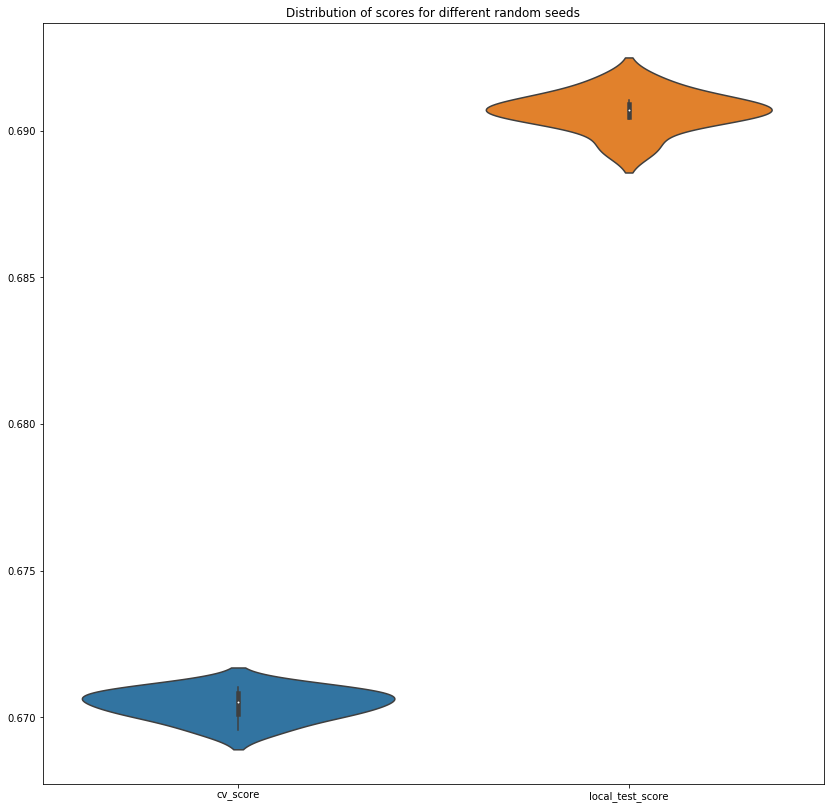

In [28]:
plt.figure(figsize=(14, 14))
sns.violinplot(x='level_0', y=0, data=eval_df[['cv_score', 'local_test_score']].unstack().reset_index())
plt.title('Distribution of scores for different random seeds')
plt.ylabel('')
plt.xlabel('')
plt.show()

In [29]:
eval_df['local_test_score'].describe()

count    8.000000
mean     0.690655
std      0.000639
min      0.689415
25%      0.690450
50%      0.690701
75%      0.690921
max      0.691651
Name: local_test_score, dtype: float64

The seed really does have a huge influence on the score. And the influence shown here is evalulated on the whole training set, it is surely even stronger on the ~ 50k rows in the public test set. And keep in mind that the statistic where calculated on a small sample of only 8 seeds.

# Possible Shortcomings

- The validation technique shown in this kernel only evaluates the model on a subset of the data. It would be ideal to wrap the procedure in another K-Fold cross-validation, but that is computationally hardly feasible (except for seed tuning where it is absolutely necessary).
- The model behaves differently when the data in the local test set is added to the training data (e. g. batches are shuffled differently). Thus, it is impossible to tune the seed on a model that is exactly the same as the one used for submitting.
- When tuning the model using the shown technique, you will tune it so that it behaves ideally with ~1M training samples. The best architecture for the model also changes when more training data is added (e. g. less need for regularization), so it might again not behave ideally when submitting.

# Takeaway

- The much higher scores on the leaderboard compared to CV scores are caused by a low correlation between folds of K-Fold CV.
- When tuning a model, you have to find the best tradeoff between CV score and correlation between folds.
- The seed is a valid hyperparameter to tune when not tuning it to the public LB.
- Because the seed has a huge influence on the score, the LB score of top public kernels is not a good indicator on how good the model architecture is.
- Although this is a kernels-only competition, local compute does matter a lot because you will likely not be able to achieve a good score on the leaderboard without tuning the seed.

All of the points above are my current beliefs. I might be wrong about some of them. I'm looking forward to discussion in the comments. Thanks for reading!

__Note: Version 1 is the one scoring 0.696 on the Leaderboard. The only difference is that `enable_local_test` is set to `False`. Runtime is also only 70 Minutes.__